# Heart Disease Classification Project

This notebook implements a comprehensive analysis and classification of heart disease data using multiple machine learning approaches.

In [18]:
import warnings
warnings.filterwarnings('ignore')

## Dataset Description

The Heart Disease dataset dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V. It contains 76 attributes, including the predicted attribute, but all published experiments refer to using a subset of 14 of them. The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease.

source: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

Here are the features:

1. **age**: Age in years

2. **sex**: Sex (1 = male, 0 = female)
3. **cp**: Chest pain type
   - Value 0: Typical angina
   - Value 1: Atypical angina
   - Value 2: Non-anginal pain
   - Value 3: Asymptomatic
4. **trestbps**: Resting blood pressure (in mm Hg)
5. **chol**: Serum cholesterol in mg/dl
6. **fbs**: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. **restecg**: Resting electrocardiographic results
   - Value 0: Normal
   - Value 1: Having ST-T wave abnormality
   - Value 2: Showing probable or definite left ventricular hypertrophy
8. **thalach**: Maximum heart rate achieved
9. **exang**: Exercise induced angina (1 = yes; 0 = no)
10. **oldpeak**: ST depression induced by exercise relative to rest
11. **slope**: The slope of the peak exercise ST segment
   - Value 0: Downsloping
   - Value 1: Flat (horizontal)
   - Value 2: Upsloping
12. **ca**: Number of major vessels colored by fluoroscopy (0-3)
13. **thal**: Thalassemia
   - Value 1: Normal
   - Value 2: Fixed defect
   - Value 3: Reversible defect
14. **target**: Diagnosis of heart disease (0 = absence, 1 = presence)

The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, learning_curve

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Configure visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

# igore FutureWarning where calling sort_value
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Loading the Dataset

In [22]:
# Load the dataset
df = pd.read_csv('heart.csv')

## 2. Exploratory Data Analysis and Data Preprocessing

Let's examine and clean our dataset:

### 2.1 Initial Data Overview

In [25]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nFirst few rows:")
df.head()

Dataset Shape: (1025, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

First few rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [26]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Find unique values for each column
len_unique = {}
for col in df.columns:
    len_unique[col]=len(df[col].unique())
print("\nUnique values for each column:", len_unique)

# Display basic statistics
print("\nBasic statistics:")
df.describe()

Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Number of duplicate rows: 723

Unique values for each column: {'age': 41, 'sex': 2, 'cp': 4, 'trestbps': 49, 'chol': 152, 'fbs': 2, 'restecg': 3, 'thalach': 91, 'exang': 2, 'oldpeak': 40, 'slope': 3, 'ca': 5, 'thal': 4, 'target': 2}

Basic statistics:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


**The initial data exploration reveals:**
- Dataset shape: 1025 rows × 14 columns
- No missing values in any columns
- 723 duplicate rows identified
- Features include both continuous measurements (age, blood pressure, cholesterol) and categorical variables (sex, chest pain type)

### 2.2 Target Variable Distribution

Proportion of positive cases: 51.32%


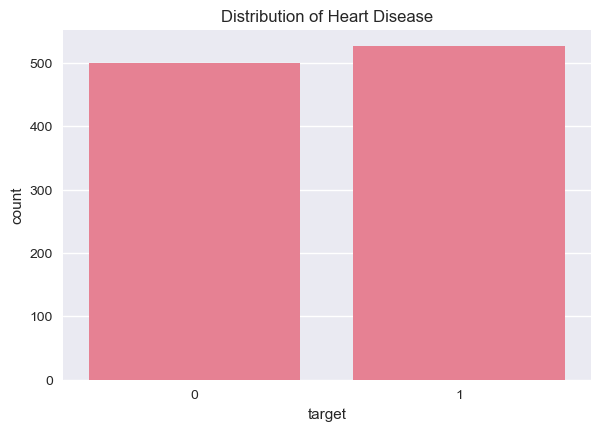

In [29]:
# Distribution of target variable
print(f"Proportion of positive cases: {len(df[df['target'] == 1]) / len(df):.2%}")

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='target')
plt.title('Distribution of Heart Disease')
plt.show()

**The target variable visualization shows:**
- Binary classification problem (0 = no heart disease, 1 = heart disease present)
- Nearly balanced dataset with approximately 51.3% positive cases
- Distribution plot indicates good representation of both classes, which is beneficial for model training

### 2.3 Age and Gender Analysis

Percentage of male: 69.56% | Percentage of female: 30.44%


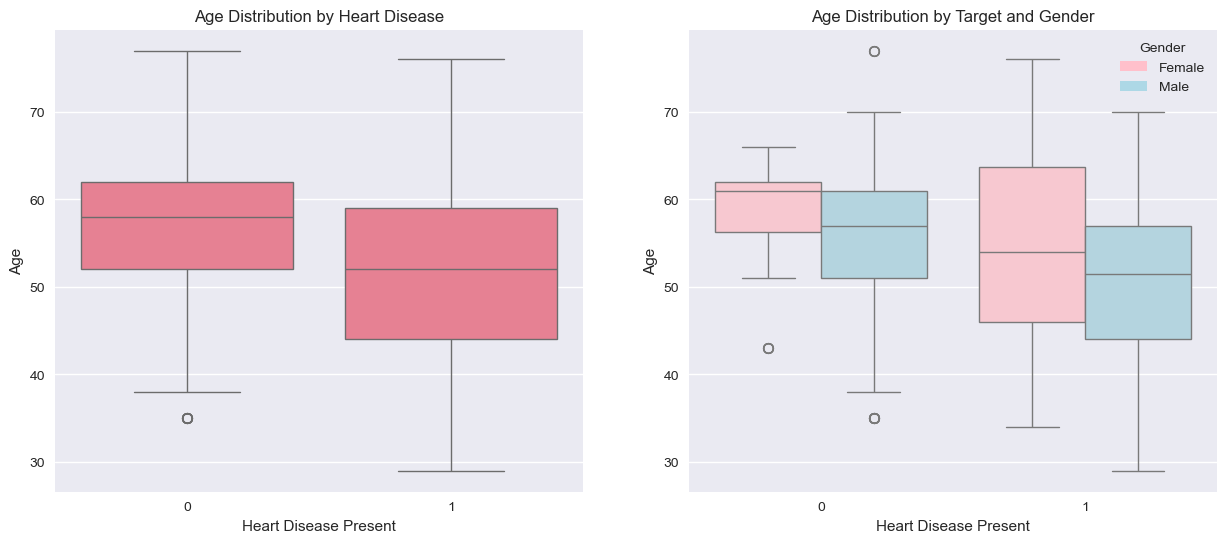

In [32]:
plt.figure(figsize=(15, 6))

# Age distribution by target
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='target', y='age')
plt.title('Age Distribution by Heart Disease')
plt.xlabel('Heart Disease Present')
plt.ylabel('Age')

# Age distribution by target and gender
sex_counts = df['sex'].value_counts(normalize=True) * 100
print("Percentage of male: {:.2f}%".format(sex_counts[1]), 
      "| Percentage of female: {:.2f}%".format(sex_counts[0]))

plt.subplot(1, 2, 2)
ax = sns.boxplot(data=df, x='target', y='age', hue='sex', palette=['pink', 'lightblue'])
plt.title('Age Distribution by Target and Gender')
plt.xlabel('Heart Disease Present')
plt.ylabel('Age')

# Create custom legend handles
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='pink', label='Female'),
                  Patch(facecolor='lightblue', label='Male')]

# Add the custom legend
plt.legend(handles=legend_elements, title='Gender')
plt.show()

**The age distribution plots reveal:**

The dataset skews male (about 70% male and 30& female).

**Patients with heart disease (target=1) do tend to be slightly younger on average** than those without. When we break it down by gender, we also see that:

-   **Men who have heart disease** present at **younger ages** (their median age is lower) than **women who have heart disease.**
-   Conversely, among those without heart disease, men again trend slightly younger than women, though the gap is smaller.

This suggests a **possible earlier onset** (or earlier detection) of heart disease in men, whereas women who develop heart disease in this dataset are often older.

### 2.4 Clinical Features Analysis

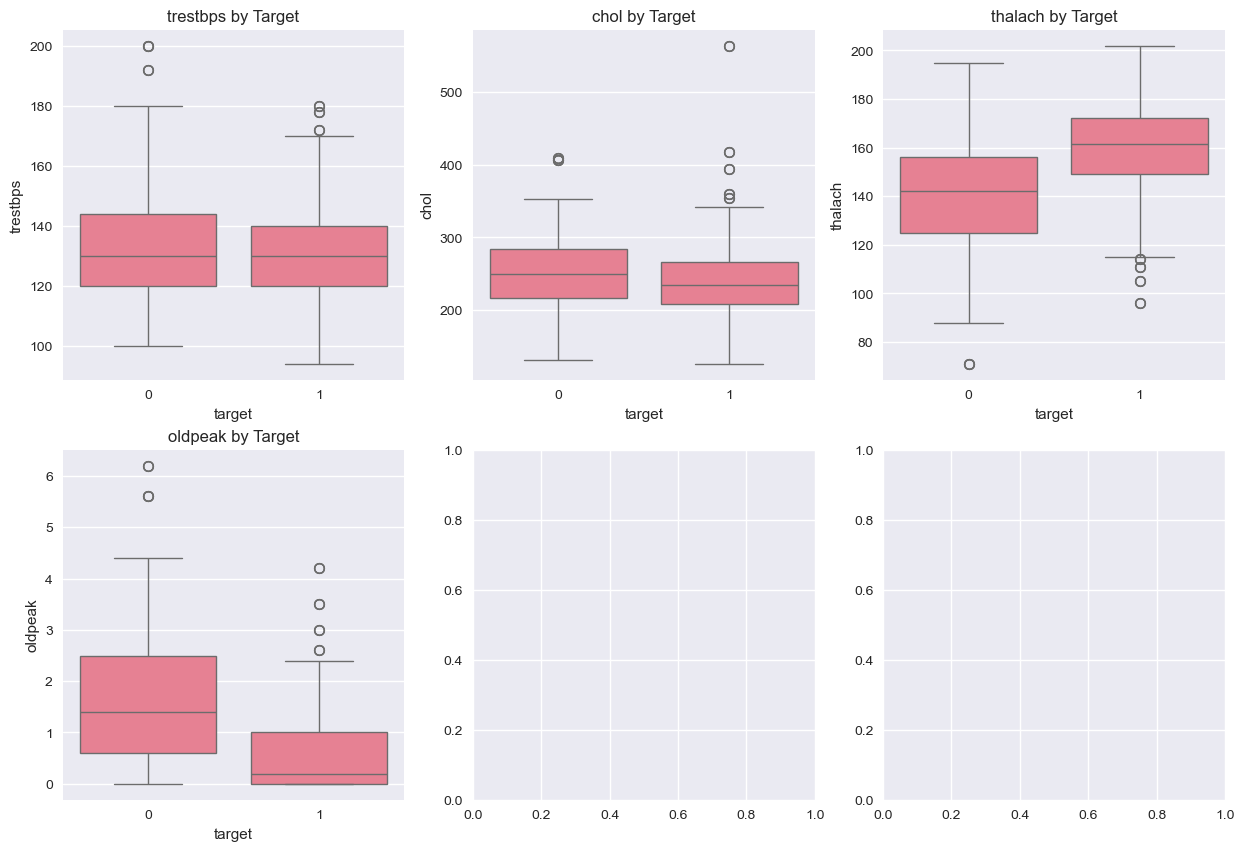

In [35]:
# Clinical features distribution
clinical_features = ['trestbps', 'chol', 'thalach', 'oldpeak']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(clinical_features):
    sns.boxplot(data=df, x='target', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature} by Target')

plt.show()

**Analysis of key clinical measurements:**
-   **Resting Blood Pressure (`trestbps`)**: The median resting blood pressure is **almost the same as patients without disease**, though there are outliers with very high BP in both groups. Overall, resting BP does not appear to differ strongly by disease status in this sample.

-   **Cholesterol (`chol`)**: CBoth groups show substantial overlap (and some extreme outliers ≥ 500 mg/dl), with only a small difference in the median levels. This suggests cholesterol alone may not be a highly discriminative feature in this particular dataset.

-   **Maximum Heart Rate (`thalach`)**: The “Disease” group shows a higher median and overall distribution for maximum achieved heart rate compared to the no‐disease group. While it may seem counterintuitive (as one might expect limited heart‐rate response in more diseased hearts), in this dataset higher max‐HR measurements appear associated with having heart disease—likely reflecting the presence of individuals who can mount a stress response but still manifest other disease indicators.

-   **ST Depression (`oldpeak`)**: Those **without disease** have a **higher median** ST depression, whereas patients with disease often show lower ST depression---though the "no disease" group has considerable variability and a number of outliers.

### 2.5 Medical Risk Factors

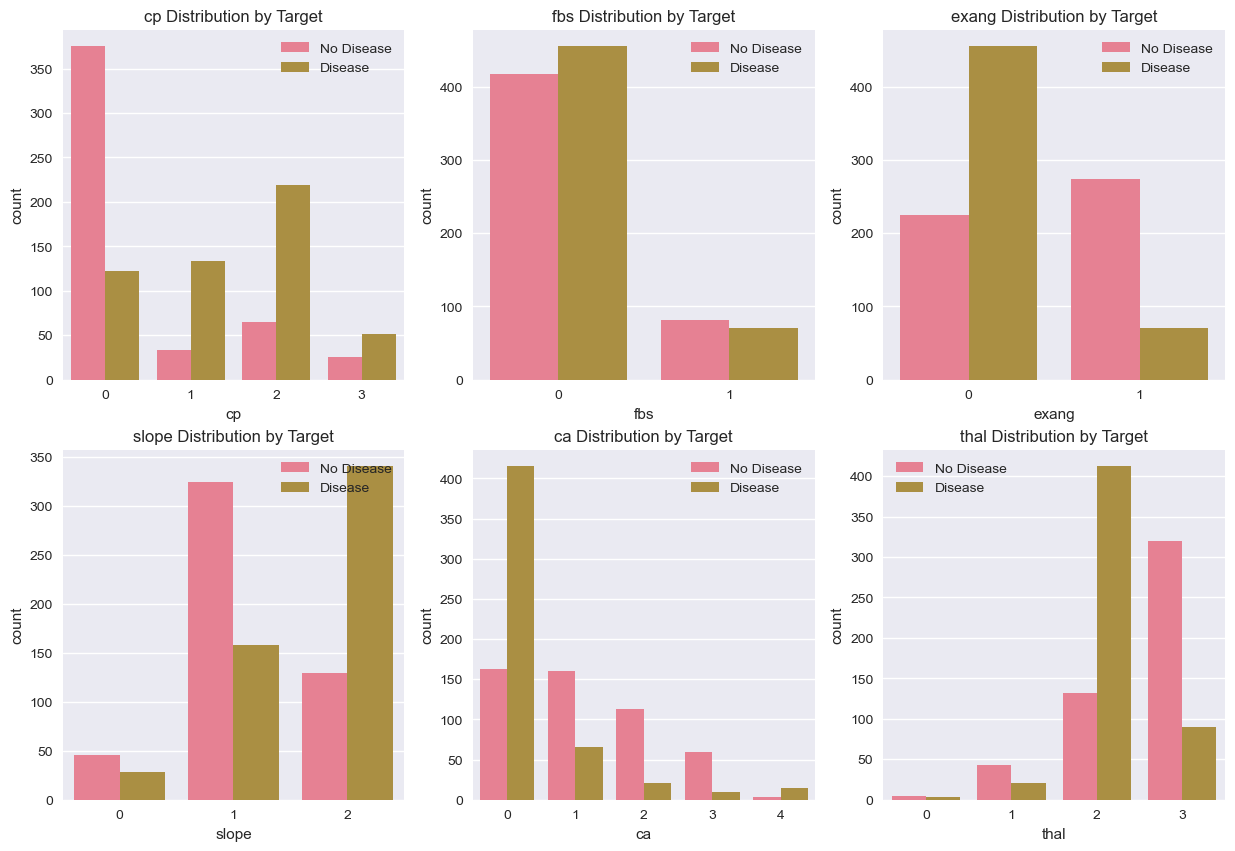

In [38]:
# Analyze key risk factors
risk_factors = ['cp','fbs', 'exang', 'slope', 'ca', 'thal']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, factor in enumerate(risk_factors):
    sns.countplot(data=df, x=factor, hue='target', ax=axes[idx])
    axes[idx].set_title(f'{factor} Distribution by Target')
    axes[idx].legend(['No Disease', 'Disease'])

plt.show()

**Categorical risk factors show distinct patterns:**
- **Chest Pain Type (`cp`)**: **Typical angina (CP=0)** appears to be most prevalent among the no‐disease group, while atypical angina (CP=1), non‐anginal pain (CP=2), and asymptomatic presentations (CP=3) tend to be more common in the group that does have heart disease with **non-anginal pain** being most common in those with disease.

- **Fasting Blood Sugar (`fbs`)**: The vast majority of both groups have a **normal fasting blood sugar (fbs=0).** A smaller share of each group shows elevated blood sugar (fbs=1).

-   **Exercise-Induced Angina (`exang`)**: Having *no* exercise-induced angina (exang=0) is **more frequent** among those **with heart disease**; by contrast, exang=1 appears more in the no‐disease group.

-   **Slope of ST Segment (`slope`)**: A **downsloping ST segment (slope=0)** is more associated with those who **do not have heart disease**, whereas an **upsloping ST segment (slope=2)** is much more common among disease‐positive individuals. **Flat ST slope (slope=2)** is present much more often in the no disease group vs those with disease but has a higher proportion of those with disease compared to slope 0.

-   **Number of Major Vessels (`ca`)**: A large fraction of those **with disease** have **0 major vessels** colored by fluoroscopy, while those with **1 or more** vessels colored tend to be more in the no‐disease group.

-   **Thalassemia Status (`thal`)**: "Reversible defect" (thal=3) occurs more often in the no disease group, along with "normal" (thal=1). "Fixed defect" (thal=2) occurs often in people with disease.

### 2.6 Feature Correlations

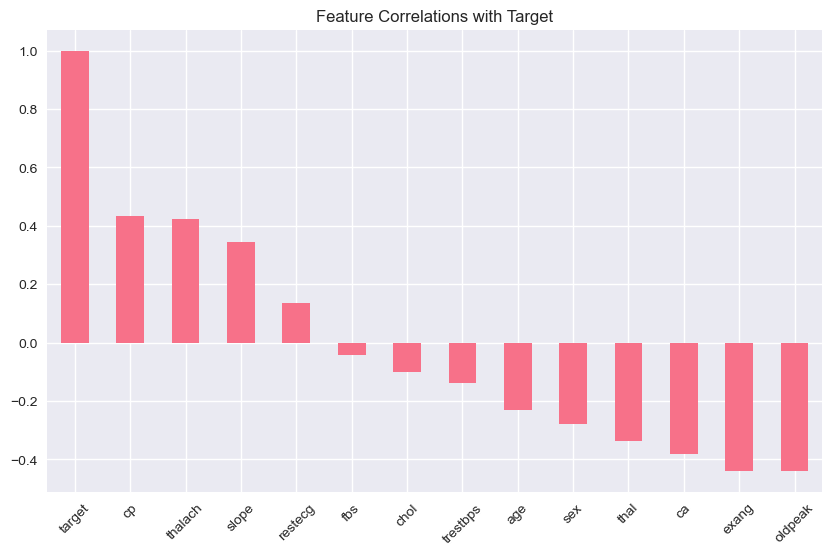

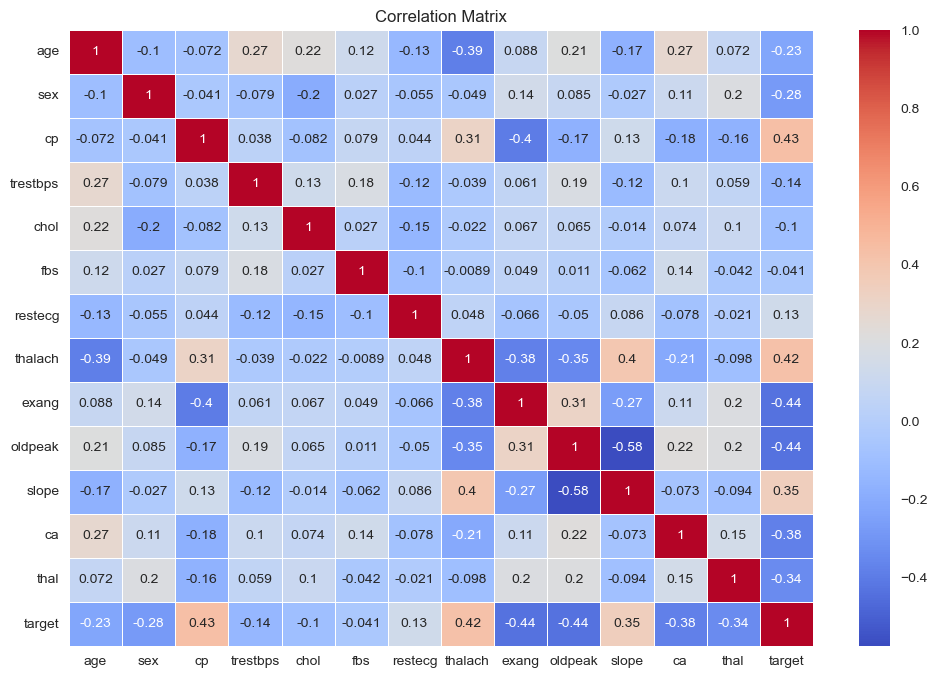

In [41]:
# Calculate feature correlations with target
correlations = df.corr()['target'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.title('Feature Correlations with Target')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### **Correlation Analysis:**

#### **Key Correlations with the target (Heart Disease):**
1. **Chest Pain Type (cp)** → *0.43*
   - Moderate positive correlation
   - Certain chest pain types indicate higher likelihood of heart disease
   - Significant diagnostic indicator

2. **Maximum Heart Rate (thalach)** → *0.42*
   - Moderate positive correlation
   - Higher exercise heart rates linked to increased disease probability

3. **ST Segment Slope (slope)** → *0.35*
   - Moderate positive correlation
   - Steeper slopes during peak exercise associated with heart disease

4. **Exercise-Induced Angina (exang)** → *-0.44*
   - Moderate negative correlation
   - Counterintuitive finding: exercise-induced chest pain linked to lower disease probability
   - May indicate data imbalance or specific dataset patterns

5. **ST Depression (oldpeak)** → *-0.44*
   - Moderate negative correlation
   - Unexpected finding: greater ST depression linked to lower disease risk
   - Requires further clinical investigation

6. **Number of Major Vessels (ca)** → *-0.38*
   - Moderate negative correlation
   - Unusual finding: more blocked vessels associated with lower risk
   - Possible feature misinterpretation

7. **Thalassemia (thal)** → *-0.34*
   - Moderate negative correlation

8. **Sex** → *-0.28*
   - Males show slightly lower disease probability

9. **Age** → *-0.23*
   - Unexpected negative correlation with age
   - Warrants further investigation

#### **Notable Feature-to-Feature Correlations:**

1. **oldpeak → slope**: *-0.58*
  - Strong negative correlation between ST depression and slope

2. **cp → exang**: *-0.40*
  - Inverse relationship between chest pain types and exercise-induced angina

3. **exang → thalach**: *-0.38*
  - Exercise-induced angina associated with lower max heart rates

4. **cp → thalach**: *0.31*
  - Certain chest pain types correlate with higher exercise heart rates

#### **Summary of Strongest Correlations**

##### Positive Correlations with Heart Disease
- Chest pain type (cp)
- Maximum heart rate (thalach)
- ST Segment Slope (slope)

##### Negative Correlations with Heart Disease
- ST depression (oldpeak)
- Exercise induced angina (exang)
- Number of vessels (ca)

### 2.7 Data Preprocessing

In [44]:
# Define preprocessing functions

# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Identify numerical and categorical columns
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['cp', 'thal', 'slope', 'restecg']

In [45]:
# Data cleaning and feature engineering

# Handle outliers in numerical features
df_clean = remove_outliers(df, numerical_features)
print(f"Rows after outlier removal: {len(df_clean)} (removed {len(df) - len(df_clean)} rows)")

# Separate features and target
X = df_clean.drop('target', axis=1)
y = df_clean['target']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_features)

Rows after outlier removal: 964 (removed 61 rows)


In [46]:
# Train/test split and scaling

# Split the data
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Scale only the numerical features
scaler = StandardScaler()
X_train = X_train_unscaled.copy()
X_test = X_test_unscaled.copy()
X_train[numerical_features] = scaler.fit_transform(X_train_unscaled[numerical_features])
X_test[numerical_features] = scaler.transform(X_test_unscaled[numerical_features])

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nFeatures after one-hot encoding:", X_train.columns.tolist())


Training set shape: (674, 23)
Testing set shape: (290, 23)

Features after one-hot encoding: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'slope_0', 'slope_1', 'slope_2', 'restecg_0', 'restecg_1', 'restecg_2']


## 3. Feature Selection

In [48]:
from Feature_selection import autoFeatureSelector

#### Find best features

In [50]:
# `num_output_features` specifies the number of features to select for each method.
# The `autoFeatureSelector` function applies multiple feature selection methods 
# (e.g., Pearson correlation, chi-square test, RFE, etc.) and combines their results
# by voting to identify the most important features.

best_features = autoFeatureSelector(
    X,
    y,
    methods=['pearson', 'chi-square', 'rfe', 'log-reg', 'rf', 'lgbm'],  # List of feature selection methods
    num_output_features=5  # Number of features to select per method
)

# Output the final list of selected features after voting
best_features

     Feature  pearson  chi-square    rfe  log-reg     rf   lgbm  Total
9    oldpeak     True        True   True     True   True   True      6
7    thalach     True       False   True     True   True   True      5
2         cp     True        True   True     True   True  False      5
11        ca     True        True   True     True   True  False      5
12      thal    False       False   True     True   True  False      3
8      exang     True        True  False    False  False  False      2
3   trestbps    False       False  False    False  False   True      1
1        sex    False        True  False    False  False  False      1
4       chol    False       False  False    False  False   True      1
0        age    False       False  False    False  False   True      1
10     slope    False       False  False    False  False  False      0
6    restecg    False       False  False    False  False  False      0
5        fbs    False       False  False    False  False  False      0


['oldpeak', 'thalach', 'cp', 'ca', 'thal']

In [51]:
# First, identify which encoded columns correspond to each categorical feature                                                 
encoded_feature_map = {                                                                                                        
    'cp': [col for col in X_train.columns if col.startswith('cp_')],                                                           
    'thal': [col for col in X_train.columns if col.startswith('thal_')]                                                        
}   

# Create list of columns to keep                                                                                               
columns_to_keep = []                                                                                                           
for feature in best_features:                                                                                                  
    if feature in ['cp', 'thal']:                                                                                              
        # If feature is categorical, add all its encoded columns                                                               
        columns_to_keep.extend(encoded_feature_map[feature])                                                                   
    else:                                                                                                                      
        # If feature is not categorical, add it directly                                                                       
        columns_to_keep.append(feature) 

# Select features for both train and test sets                                                                                 
X_train_fs = X_train[columns_to_keep]                                                                                          
X_test_fs = X_test[columns_to_keep]  

print("\nTraining set shape:", X_train_fs.shape)
print("Testing set shape:", X_test_fs.shape)

X_train_fs.head()


Training set shape: (674, 11)
Testing set shape: (290, 11)


,oldpeak,thalach,cp_0,cp_1,cp_2,cp_3,ca,thal_0,thal_1,thal_2,thal_3
722,-0.916660,0.970068,False,False,True,False,1,False,False,True,False
244,1.386881,0.703110,False,False,True,False,0,False,False,True,False
482,3.114538,-1.254586,True,False,False,False,3,False,False,False,True
929,1.386881,-0.809655,True,False,False,False,2,False,False,False,True
227,-0.628718,-0.053273,False,False,True,False,1,False,False,True,False


**Selected Features:**

1. oldpeak: ST depression induced by exercise relative to rest
2. thalach: Maximum heart rate achieved
3. cp: Chest pain type
    - Value 0: Typical angina
    - Value 1: Atypical angina
    - Value 2: Non-anginal pain
    - Value 3: Asymptomatic
4. ca: Number of major vessels colored by fluoroscopy (0-3)
5. thal: Thalassemia
    - Value 1: Normal
    - Value 2: Fixed defect
    - Value 3: Reversible defect

To avoid overfitting in decision tree and random forest models, we consulted pharmacists. Domain knowledge indicates that the 'oldpeak' and 'ca' features should be positively correlated with heart disease risk—higher values should indicate a greater likelihood of heart disease. However, our analysis revealed a negative correlation, which contradicts this domain knowledge. As a result, we decided to remove these two features to improve generalization.

**Selected Features for Decision Tree and Random Forest:**

1. cp (Chest Pain Type) – Strongest positive correlation (0.43), a key diagnostic factor
2. thalach (Max Heart Rate) – Strong correlation (0.42), often linked to heart disease severity
3. thal (Thalassemia) – Moderate correlation (-0.34), relevant to cardiovascular health

In [53]:
# Further reduce number of features to prevent overfitting in Decision Tree and Random Forest
X_train_fs_domain = X_train_fs[['cp_0', 'cp_1', 'cp_2', 'cp_3', 'thalach', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]
X_test_fs_domain = X_test_fs[['cp_0', 'cp_1', 'cp_2', 'cp_3', 'thalach', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]

## 4. Models

### 1. Logistic Regression

#### 1.1 Default Logistic Regression Classifier

In [57]:
# Train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Logistic Regression Model accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Model accuracy: 0.8517241379310345

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       144
           1       0.83      0.89      0.86       146

    accuracy                           0.85       290
   macro avg       0.85      0.85      0.85       290
weighted avg       0.85      0.85      0.85       290



#### 1.2 Hyperparameter Tuning with GridSearchCV

In [59]:
# Define parameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]
}

# Grid search with cross validation
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    scoring='recall',
    cv=5,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters and model
print("\nBest Parameters:", grid_search.best_params_)
y_pred_tuned = grid_search.predict(X_test)

# Print results for tuned model
print("\nTuned Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'C': 0.001, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'}

Tuned Logistic Regression Results:
Accuracy: 0.7103448275862069

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.42      0.59       144
           1       0.64      0.99      0.78       146

    accuracy                           0.71       290
   macro avg       0.81      0.71      0.68       290
weighted avg       0.81      0.71      0.68       290



#### 1.3 Feature Selection and Re-Evaluation

In [61]:
# Feature selected model
logistic_fs = LogisticRegression(max_iter=1000)
logistic_fs.fit(X_train_fs, y_train)
y_pred_fs = logistic_fs.predict(X_test_fs)

# Print results for feature selected model
print("\nFeature Selected Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_fs))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_fs))


Feature Selected Logistic Regression Results:
Accuracy: 0.8448275862068966

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       144
           1       0.84      0.86      0.85       146

    accuracy                           0.84       290
   macro avg       0.84      0.84      0.84       290
weighted avg       0.84      0.84      0.84       290



In [62]:
# Grid search with feature selection
grid_search_fs = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    scoring='recall',
    cv=5,
    verbose=1
)

# Fit grid search on feature selected data
grid_search_fs.fit(X_train_fs, y_train)

# Get predictions
print("\nBest Parameters (Feature Selected):", grid_search_fs.best_params_)
y_pred_fs_tuned = grid_search_fs.predict(X_test_fs)

# Print results for tuned feature selected model
print("\nTuned Feature Selected Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_fs_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_fs_tuned))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters (Feature Selected): {'C': 0.001, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'}

Tuned Feature Selected Logistic Regression Results:
Accuracy: 0.7379310344827587

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.51      0.66       144
           1       0.67      0.96      0.79       146

    accuracy                           0.74       290
   macro avg       0.80      0.74      0.72       290
weighted avg       0.79      0.74      0.72       290



#### 1.4 Logistic Regression Comparison and Analysis 

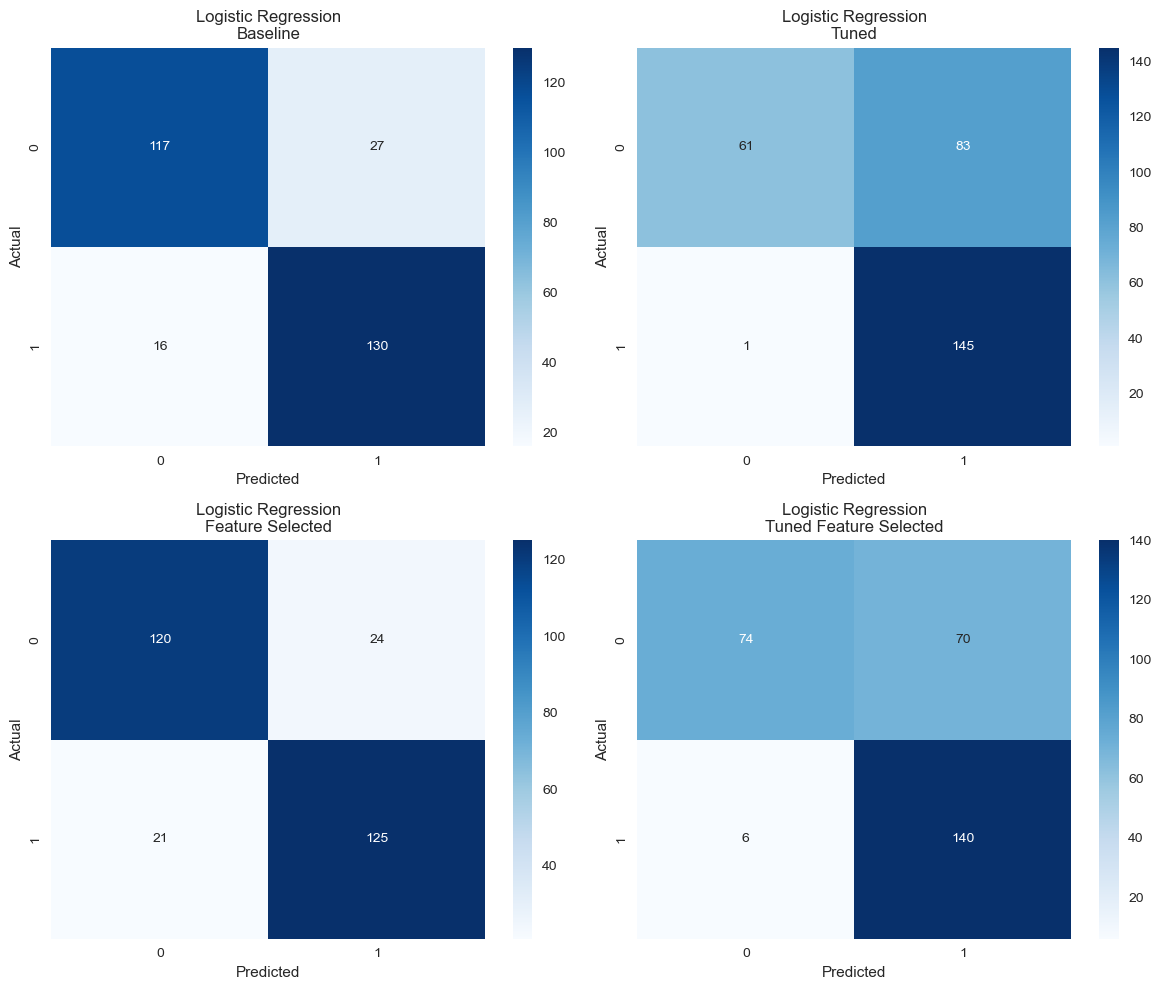


Model Comparison Results:
------------------------
                        Accuracy  Precision (Class 1)  Recall (Class 1)  \
Model                                                                     
Baseline                   0.852                0.828             0.890   
Tuned                      0.710                0.636             0.993   
Feature Selected           0.845                0.839             0.856   
Tuned Feature Selected     0.738                0.667             0.959   

                        F1-score (Class 1)  
Model                                       
Baseline                             0.858  
Tuned                                0.775  
Feature Selected                     0.847  
Tuned Feature Selected               0.787  


In [64]:
# Plot confusion matrices for all four models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define model names and predictions
models = {
    'Baseline': y_pred,
    'Tuned': y_pred_tuned,
    'Feature Selected': y_pred_fs,
    'Tuned Feature Selected': y_pred_fs_tuned
}

for (title, predictions), ax in zip(models.items(), axes.ravel()):
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Logistic Regression\n{title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Create comparison DataFrame
metrics = {
    'Model': ['Baseline', 'Tuned', 'Feature Selected', 'Tuned Feature Selected'],
    'Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_tuned),
        accuracy_score(y_test, y_pred_fs),
        accuracy_score(y_test, y_pred_fs_tuned)
    ]
}

for i, predictions in enumerate([y_pred, y_pred_tuned, y_pred_fs, y_pred_fs_tuned]):
    report = classification_report(y_test, predictions, output_dict=True)
    metrics[f'Precision (Class 1)'] = metrics.get(f'Precision (Class 1)', []) + [report['1']['precision']]
    metrics[f'Recall (Class 1)'] = metrics.get(f'Recall (Class 1)', []) + [report['1']['recall']]
    metrics[f'F1-score (Class 1)'] = metrics.get(f'F1-score (Class 1)', []) + [report['1']['f1-score']]

results_df = pd.DataFrame(metrics)
results_df = results_df.set_index('Model')
print("\nModel Comparison Results:")
print("------------------------")
print(results_df.round(3))

##### **Comparison and Analysis**
                                                                                 
1. **Baseline Model**                                                          
- Accuracy: 85.2%                                                                
- Precision: 0.828                                                               
- Recall: 0.890                                                                  
- F1-score: 0.858                                                                
- Shows good overall performance with high recall but moderate precision         
- Performs well at identifying positive cases (high recall) but has some false   
positives                                                                        
                                                                                 
2. **Tuned Model (with GridSearchCV)**                                        
- Accuracy: 71.0%                                                                
- Precision: 0.636                                                               
- Recall: 0.993                                                                  
- F1-score: 0.775                                                                
- Lower overall accuracy but extremely high recall                               
- Significant drop in precision indicates model is more likely to predict positive
cases                                                                            
- Hyperparameter tuning optimized for recall, resulting in more false positives  
                                                                                 
3. **Feature Selected Model**                                                 
- Accuracy: 84.5%                                                                
- Precision: 0.839                                                               
- Recall: 0.856                                                                  
- F1-score: 0.847                                   
- Most balanced precision-recall trade-off               
                                                                                 
4. **Feature Selected + Tuned Model**                                           
- Accuracy: 73.8%                                                                
- Precision: 0.667                                                               
- Recall: 0.959                                                                  
- F1-score: 0.787                                                                
- Similar pattern to non-feature-selected tuned model                            
- High recall but lower precision                                                
- Shows that tuning consistently prioritizes recall over precision               
                                                                                 
**Key Insights**                                                                
                                                                                 
1. **Feature Selection Impact**                                                  
   - Feature selection led to slightly more balanced precision and recall at the cost of slight accuracy.
   - Suggests that removing irrelevant features does not affect the performance much.
                                                                                 
2. **Hyperparameter Tuning Effects**                                             
   - Tuning consistently increased recall at the expense of precision            
   - Led to lower overall accuracy but better identification of positive cases   
   - This trade-off might be desirable in medical diagnosis where missing a disease is more costly than false positives
                                                                                 
3. **Best Model Selection**                                                      
   - For balanced performance: Base model (85.2% accuracy)           
   - For minimizing missed cases: Tuned Model (99.3% recall)                     
   - Choice depends on the specific requirements of the application              
                                                                                 
4. **Clinical Implications**                                                     
   - In heart disease diagnosis, missing a positive case (false negative) could be life-threatening
   - The tuned models' high recall might be preferable despite lower precision   
   - The feature-selected model offers the best balance if false positives are also a concern 
                                                                                 
**Recommendation**                                                              
                                                                                 
For heart disease prediction, the tuned model (either with or without feature selection) would be recommended due to its high recall, ensuring fewer missed cases. While this comes at the cost of more false positives, in medical diagnosis, it's generally better to have false positives that can be ruled out with additional testing than to miss actual cases of heart disease.  

### 2. Decision Tree Classifier

#### 2.1 Baseline Model

In [68]:
dt_model_base = DecisionTreeClassifier(random_state = 42)
dt_model_base.fit(X_train, y_train)
y_pred_base = dt_model_base.predict(X_test)

accuracy_dt_base = accuracy_score(y_test, y_pred_base)
print("Baseline Model Accuracy: ", accuracy_dt_base)
print(classification_report(y_test, y_pred_base))

Baseline Model Accuracy:  0.9896551724137931
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       144
           1       1.00      0.98      0.99       146

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290



#### 2.2 Tuned Baseline Model

In [228]:
# defining parameters to test in grid search
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 5],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
}

# creating grid search object with cross-validation
dt_model_base_tuned = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    grid_param,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1
)

#training the model with grid searvh
dt_model_base_tuned.fit(X_train, y_train)
print("\n Best Parameters: ", dt_model_base_tuned.best_params_)

#making predictions using the tuned model
y_pred_base_tuned = dt_model_base_tuned.predict(X_test)
accuracy_dt_tuned = accuracy_score(y_test, y_pred_base_tuned)
print("Tuned Baseline Model Accuracy: ", accuracy_dt_tuned)
print(classification_report(y_test, y_pred_base_tuned))


 Best Parameters:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Baseline Model Accuracy:  0.8620689655172413
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       144
           1       0.92      0.79      0.85       146

    accuracy                           0.86       290
   macro avg       0.87      0.86      0.86       290
weighted avg       0.87      0.86      0.86       290



#### 2.3 Feature Selected Model

In [230]:
#creating the model using selected features
dt_model_fs = DecisionTreeClassifier(random_state=42)

#training the model
dt_model_fs.fit(X_train_fs_domain, y_train)

y_pred_fs = dt_model_fs.predict(X_test_fs_domain)
accuracy_fs = accuracy_score(y_test, y_pred_fs)
print("\nFeature Selected Model Accuracy: ", accuracy_fs)
print(classification_report(y_test, y_pred_fs))


Feature Selected Model Accuracy:  0.8896551724137931
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       144
           1       0.93      0.84      0.88       146

    accuracy                           0.89       290
   macro avg       0.89      0.89      0.89       290
weighted avg       0.89      0.89      0.89       290



#### 2.4 Tuned Feature Selected Model

In [232]:
#applying grid search to feature slected
dt_model_fs_tuned = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    grid_param,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

#training the model on feature-selected data
dt_model_fs_tuned.fit(X_train_fs_domain, y_train)
print("\nBest Parameters (feature selected): ", dt_model_fs_tuned.best_params_)

#making predictions with tuned feature-selected model
y_pred_fs_tuned = dt_model_fs_tuned.predict(X_test_fs_domain)
accuracy_fs_tuned = accuracy_score(y_test, y_pred_fs_tuned)
print("tuned feature Selected Model accuracy: ", accuracy_fs_tuned)
print(classification_report(y_test, y_pred_fs_tuned))


Best Parameters (feature selected):  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
tuned feature Selected Model accuracy:  0.8137931034482758
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       144
           1       0.79      0.86      0.82       146

    accuracy                           0.81       290
   macro avg       0.82      0.81      0.81       290
weighted avg       0.82      0.81      0.81       290



#### 2.4 Visualization

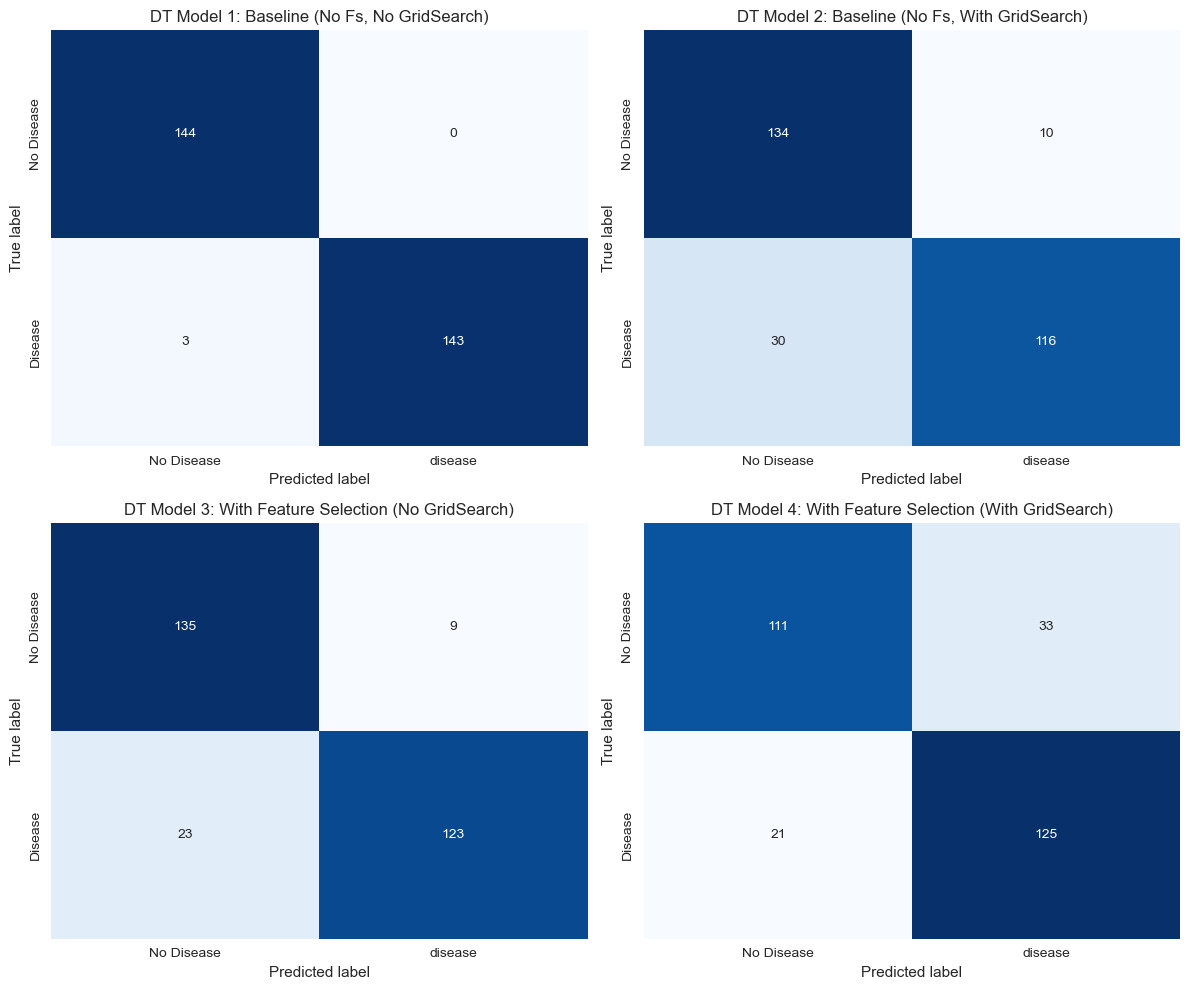

In [76]:
#generating predictions for all 4 models of dtree for comparison
y_pred_dt1 = dt_model_base.predict(X_test)
y_pred_dt2 = dt_model_base_tuned.predict(X_test)
y_pred_dt3 = dt_model_fs.predict(X_test_fs_domain)
y_pred_dt4 = dt_model_fs_tuned.predict(X_test_fs_domain)

#creating confustion matrices for all models
cm_dt1 = confusion_matrix(y_test, y_pred_dt1)
cm_dt2 = confusion_matrix(y_test, y_pred_dt2)
cm_dt3 = confusion_matrix(y_test, y_pred_dt3)
cm_dt4 = confusion_matrix(y_test, y_pred_dt4)

#setting up visualization grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

#titles for each confustion matrix
titles = [
    "DT Model 1: Baseline (No Fs, No GridSearch)",
    "DT Model 2: Baseline (No Fs, With GridSearch)",
    "DT Model 3: With Feature Selection (No GridSearch)",
    "DT Model 4: With Feature Selection (With GridSearch)",
]

#function to create confusion matrix
def plot_confusion_matrix_dt(ax, cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',cbar=False,
                xticklabels=["No Disease", "disease"],
                yticklabels=["No Disease", "Disease"], ax = ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

#creating all 4 confusion matrix
for ax, cm, title in zip(axes.ravel(), [cm_dt1, cm_dt2, cm_dt3, cm_dt4], titles):
    plot_confusion_matrix_dt(ax, cm, title)

plt.tight_layout()
plt.show()

#### 2.5 Accuracy of Decision Tree with different Models


In [78]:
print("\nBaseline Model Accuracy: ", accuracy_dt_base)
print("Tuned Baseline Model Accuracy: ", accuracy_dt_tuned)
print("\nFeature Selected Model Accuracy: ", accuracy_fs)
print("Tuned Feature Selected Model accuracy: ", accuracy_fs_tuned)


Baseline Model Accuracy:  0.9896551724137931
Tuned Baseline Model Accuracy:  0.8620689655172413

Feature Selected Model Accuracy:  0.8896551724137931
Tuned Feature Selected Model accuracy:  0.8137931034482758


#### 2.6 Decision Tree Analysis

**Models Evaluated:**

**2.6.1 Baseline Model (No Feature Selection, No GridSearch):**
- **Accuracy:** 0.9897 
- **Confusion Matrix:**
        - TP:144, TN:143, FP:0, FN:3 
    - **Observation:** 
        - Very High Accuracy 
        - Likely Overfitting due to 0 FP and low FN 
        - may not generalize well to new data

**2.6.2 Baseline Model with GridSearch:** 
- **Accuracy:** 0.8621
- **Confusion Matrix:**
        - TP:134, TN:116, FP:10, FN:30 
    - **Observation:**
        - Reduced overfitting compared to basemodel. 
        - Hyperparameters were tuned using gridsearch 
        - Lower accuracy but more realistic performance

**2.6.3 Model with Feature Selection (No GridSearch):** 
- **Accuracy:** 0.8897 
- **Confusion Matrix:**
        - TP:135, TN:123, FP:9, FN:33 
    - **Observation:** 
        - slightly better accuracy than the baseline with gridsearch

**2.6.4 Model with Feature Selection and GridSearch** 
- **Accuracy:** 0.8138 
- **Confusion Matrix:**
        - TP:111, TN:125, FP:31, FN:33 
    - **Observation:** 
        - Lowest accuracy but Most generalizable model 
        - Hyperparameters were tuned and feature selection was applied reducing overfitting. 
        - likely to perform well on unseen data

**Key Insights:**

**NoFeature Selection and no GridSearch** has the **highest accuracy** but **potential overfitting**.
**GridSearch and feature selection** **reduce overfitting** but **reduces the accuracy**. 
Its a **tradeoff** between **accuracy and model generalizability**

**Conclusion:**

Model with **Feature Selection and GridSearch** is the **best model** as it **balances accuracy and generalizability**, making it more **reliable for real world application**. As it has lower accuracy compared to the base mode, it **provides better interpretability** and is **less likely to overfit**.

### 3. Random Forest Classifier

#### 3.1 Baseline Model (No Feature Selection, No Hyperparameter Tuning)

In [83]:
rf_model_base = RandomForestClassifier(random_state=42)
rf_model_base.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [84]:
y_pred_base = rf_model_base.predict(X_test)

In [85]:
accuracy_base = accuracy_score(y_test, y_pred_base)
print(f'Accuracy: {accuracy_base}')

Accuracy: 1.0


#### 3.2 Baseline with Hyperparamaters Tuning (No Feature Selection, with GridSearchCV)

In [87]:
param_grid = {
    'n_estimators': [100, 300, 500],  
    'max_depth': [2, 3, 5],  
    'min_samples_split': [2, 10, 20],  
    'min_samples_leaf': [1, 5, 10],  
    'max_features': ['sqrt', 'log2'] 
}

In [88]:
rf_model_base_tuned = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv = 5, 
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1
)

rf_model_base_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=1)

In [89]:
rf_model_base_tuned.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [90]:
y_pred_base_tuned = rf_model_base_tuned.best_estimator_.predict(X_test)

In [91]:
accuracy_base_tuned = accuracy_score(y_test, y_pred_base_tuned)
print(f'Accuracy: {accuracy_base_tuned}')

Accuracy: 0.9103448275862069


#### 3.3 Feature-Selected Model (With Feature Selection, No GridSearchCV)

In [93]:
rf_model_fs = RandomForestClassifier(random_state=42)
rf_model_fs.fit(X_train_fs_domain, y_train)

RandomForestClassifier(random_state=42)

In [94]:
y_pred_fs = rf_model_fs.predict(X_test_fs_domain)

In [95]:
accuracy_fs = accuracy_score(y_test, y_pred_fs)
print(f'Accuracy: {accuracy_fs}')

Accuracy: 0.8896551724137931


#### 3.4 Feature-Selected with Hyperparameter Tuning (With Feature Selection, With GridSearchCV)

In [97]:
rf_model_fs_tuned = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs = -1, 
    verbose = 1
)

rf_model_fs_tuned.fit(X_train_fs_domain, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=1)

In [98]:
rf_model_fs_tuned.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [99]:
y_pred_fs_tuned = rf_model_fs_tuned.best_estimator_.predict(X_test_fs_domain)

In [100]:
accuracy_fs_tuned = accuracy_score(y_test, y_pred_fs_tuned)
print(f'Accuracy: {accuracy_fs_tuned}')

Accuracy: 0.8379310344827586


#### 3.4 Confusion Matrices

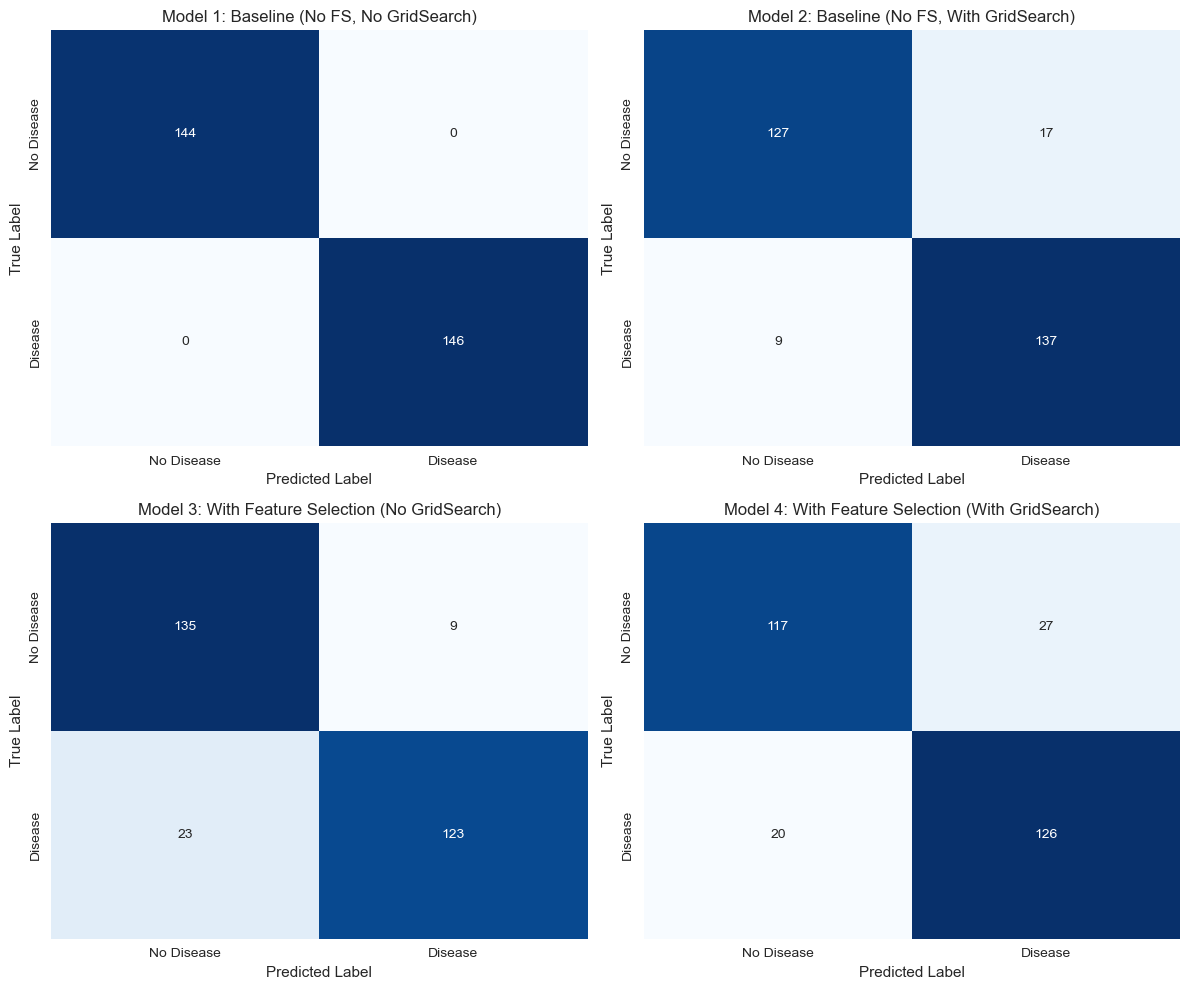

In [102]:
# Generate predictions for 4 different models
y_pred_1 = rf_model_base.predict(X_test)         # Model 1: Clean data, no feature selection
y_pred_2 = rf_model_base_tuned.best_estimator_.predict(X_test)   # Model 2: Clean data, no feature selection, with GridSearchCV
y_pred_3 = rf_model_fs.predict(X_test_fs_domain)           # Model 3: Clean data, with feature selection
y_pred_4 = rf_model_fs_tuned.best_estimator_.predict(X_test_fs_domain)    # Model 4: Clean data, feature selection, with GridSearchCV

# Compute confusion matrices
cm_1 = confusion_matrix(y_test, y_pred_base)
cm_2 = confusion_matrix(y_test, y_pred_base_tuned)
cm_3 = confusion_matrix(y_test, y_pred_fs)
cm_4 = confusion_matrix(y_test, y_pred_fs_tuned)

# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define model names for better visualization
titles = [
    "Model 1: Baseline (No FS, No GridSearch)",
    "Model 2: Baseline (No FS, With GridSearch)",
    "Model 3: With Feature Selection (No GridSearch)",
    "Model 4: With Feature Selection (With GridSearch)"
]

# Function to plot confusion matrix using seaborn heatmap
def plot_confusion_matrix(ax, cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"], ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

# Plot all four confusion matrices
for ax, cm, title in zip(axes.ravel(), [cm_1, cm_2, cm_3, cm_4], titles):
    plot_confusion_matrix(ax, cm, title)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

##### **Conclusion on Model Performance and Overfitting**

1. **Overfitting in the Baseline Models**
   - **Before Feature Selection (Model 1 & Model 2)**
     - Model 1 (Baseline, No FS, No GridSearch) achieves perfect classification:
       - True Positives (TP): 146
       - True Negatives (TN): 144
       - No misclassifications (0 FP, 0 FN).
       - This suggests the model might be overfitting, as perfect accuracy on a real-world dataset is uncommon.
     - Model 2 (Baseline, No FS, With GridSearch) introduces misclassifications:
       - FP increases to 17, FN increases to 9.
       - A slight drop in accuracy, indicating that GridSearchCV might be tuning hyperparameters in a way that reduces overfitting.

2. **Feature Selection Impacts Generalization**
   - **After Feature Selection (Model 3 & Model 4)**
     - Model 3 (With Feature Selection, No GridSearch):
       - FP: 9, FN: 23.
       - More misclassifications compared to Model 1.
       - While accuracy decreases slightly, this indicates better generalization, as the model is no longer memorizing the dataset.
     - Model 4 (With Feature Selection, With GridSearch):
       - FP increases to 27, FN increases to 20.
       - This suggests that hyperparameter tuning, specifically adjusting **max_depth**, helps control overfitting and improves the model's ability to perform well on unseen data.

**Key Takeaways**
- **Baseline Model 1 exhibits possible overfitting** (perfect accuracy).
- **Feature selection improves generalization but introduces more misclassifications** (Models 3 & 4).
- **GridSearchCV helps prevent overfitting** by tuning parameters like **max_depth**, leading to better generalization.

### 4. Stochastic Gradient Descent (SGD)

#### 4.1 Default SGD Classifier

In [106]:
# Initialize model
sgd_default = SGDClassifier(random_state=42)

# Train model
sgd_default.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [107]:
# Make predictions
y_pred_default = sgd_default.predict(X_test)

In [108]:
# Print model performance
print("Default SGD Classifier Results:")
print("---------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default))

Default SGD Classifier Results:
---------------------------
Accuracy: 0.8448275862068966

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       144
           1       0.85      0.84      0.85       146

    accuracy                           0.84       290
   macro avg       0.84      0.84      0.84       290
weighted avg       0.84      0.84      0.84       290



#### 4.2 Cross Validation


Cross-validation scores: [0.8        0.8        0.77777778 0.81481481 0.76119403]
Mean CV Score: 0.791 (+/- 0.038)


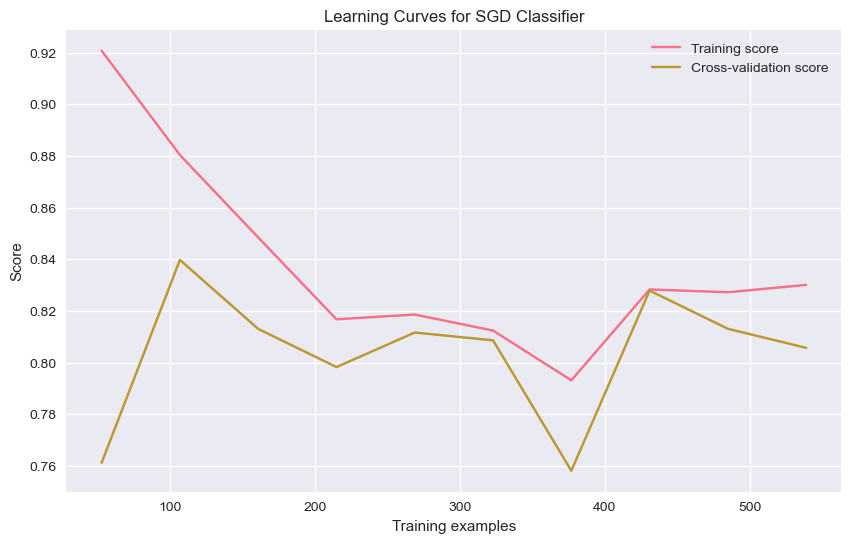

In [110]:
# Cross-validation analysis

# Perform cross-validation
cv_scores = cross_val_score(sgd_default, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    sgd_default, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, n_jobs=-1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves for SGD Classifier')
plt.legend(loc='best')
plt.grid(True)
plt.show()

**Analysis**

-   For small training sets, the **training accuracy** is high (e.g., ~0.92), indicating potential overfitting.
-   The **cross-validation score** initially lags behind, then fluctuates around 0.80--0.82 as more data is added.
-   As training size increases, the training score drops and the CV score settles, suggesting the model generalizes better but still exhibits variability.
-   Overall, the two curves do not fully converge but come closer around mid--high 0.8s, hinting that adding even more data (or tuning hyperparameters) may improve or stabilize the model performance further.

#### 4.3 Hyperparameter Tuning with GridSearchCV

In [113]:
# Define hyperparameter grid for tuning
param_grid = {
    'loss': ['modified_huber', 'log_loss'],          # Focus on probability-calibrated losses
    'penalty': ['l2', 'elasticnet'],                # Regularization methods
    'alpha': [0.0001, 0.001],                       # Lower regularization for better recall
    'learning_rate': ['adaptive'],                  # Adaptive learning rate
    'eta0': [0.01, 0.1],                           # Initial learning rate
    'class_weight': [{0:1, 1:2}, {0:1, 1:3}]       # Try different false negative penalties
}

# Perform grid search optimizing for recall
grid_search = GridSearchCV(SGDClassifier(random_state=42, 
                                       max_iter=1000, 
                                       tol=1e-3,
                                       early_stopping=True,
                                       validation_fraction=0.1),
                           param_grid,
                           scoring='recall',  # Optimize for minimizing false negatives
                           cv=5,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=SGDClassifier(early_stopping=True, random_state=42),
             param_grid={'alpha': [0.0001, 0.001],
                         'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}],
                         'eta0': [0.01, 0.1], 'learning_rate': ['adaptive'],
                         'loss': ['modified_huber', 'log_loss'],
                         'penalty': ['l2', 'elasticnet']},
             scoring='recall', verbose=1)


Best Parameters Found: {'alpha': 0.0001, 'class_weight': {0: 1, 1: 3}, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'penalty': 'l2'}

Baseline SGD Model Metrics:
---------------------------
Accuracy: 0.8448275862068966

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       144
           1       0.85      0.84      0.85       146

    accuracy                           0.84       290
   macro avg       0.84      0.84      0.84       290
weighted avg       0.84      0.84      0.84       290


Tuned SGD Model Metrics:
------------------------
Accuracy: 0.8241379310344827

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       144
           1       0.77      0.94      0.84       146

    accuracy                           0.82       290
   macro avg       0.84      0.82      0.82       290
weighted avg       0.84      

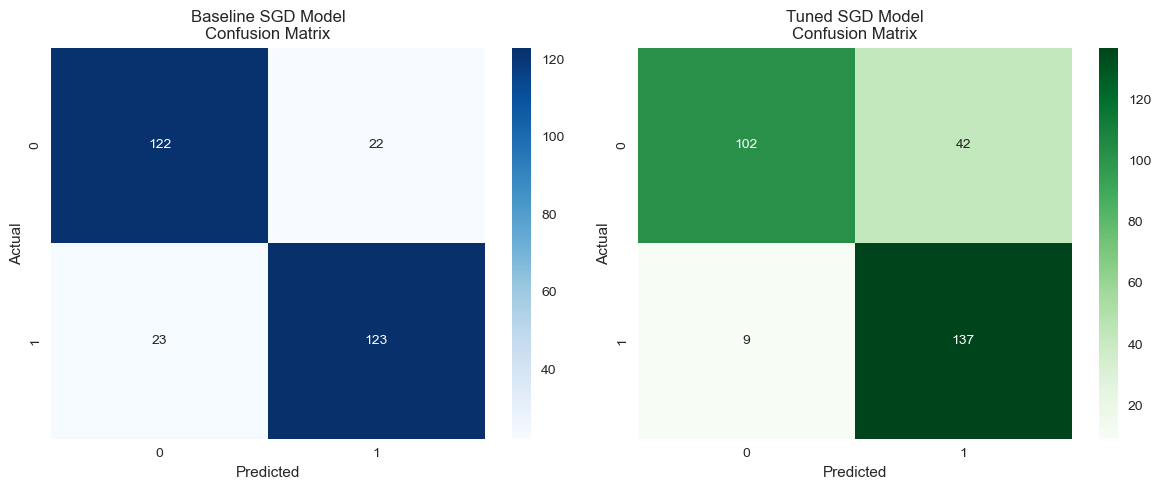

In [114]:
# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("\nBest Parameters Found:", best_params)

# Make predictions with the best model
y_pred_tuned = best_model.predict(X_test)

# Compare baseline and tuned model metrics
print("\nBaseline SGD Model Metrics:")
print("---------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default))

print("\nTuned SGD Model Metrics:")
print("------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Baseline model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_default), 
            annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Baseline SGD Model\nConfusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

# Tuned model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_tuned),
            annot=True, fmt="d", cmap="Greens", ax=ax2)
ax2.set_title("Tuned SGD Model\nConfusion Matrix") 
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()


#### 4.4 Feature Selection and Re-Evaluation

In [116]:
# Train basic SGD model with selected features
sgd_fs = SGDClassifier(random_state=42)
sgd_fs.fit(X_train_fs, y_train)

# Train grid search tuned model with selected features
sgd_fs_tuned = GridSearchCV(SGDClassifier(random_state=42, 
                                       max_iter=1000, 
                                       tol=1e-3,
                                       early_stopping=True,
                                       validation_fraction=0.1),
                           param_grid,
                           scoring='recall',  # Optimize for minimizing false negatives
                           cv=5,
                           verbose=1)
sgd_fs_tuned.fit(X_train_fs, y_train)

# Make predictions for all models
y_pred_train_sgd_fs = sgd_fs.predict(X_train_fs)
y_pred_test_sgd_fs = sgd_fs.predict(X_test_fs)
y_pred_test_fs_tuned = sgd_fs_tuned.predict(X_test_fs)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [117]:
# Calculate accuracies
accuracy_train_sgd_fs = accuracy_score(y_train, y_pred_train_sgd_fs)
accuracy_test_sgd_fs = accuracy_score(y_test, y_pred_test_sgd_fs)
accuracy_test_tuned = accuracy_score(y_test, y_pred_test_fs_tuned)


Feature Selected SGD Model Metrics:
---------------------------

Accuracy: 0.7818991097922848

Accuracy: 0.6896551724137931

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.91      0.74       144
           1       0.84      0.47      0.61       146

    accuracy                           0.69       290
   macro avg       0.74      0.69      0.67       290
weighted avg       0.74      0.69      0.67       290


Tuned Feature Selected SGD Model Metrics:
---------------------------

Accuracy: 0.8275862068965517

Classification Report:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       144
           1       0.78      0.92      0.84       146

    accuracy                           0.83       290
   macro avg       0.84      0.83      0.83       290
weighted avg       0.84      0.83      0.83       290



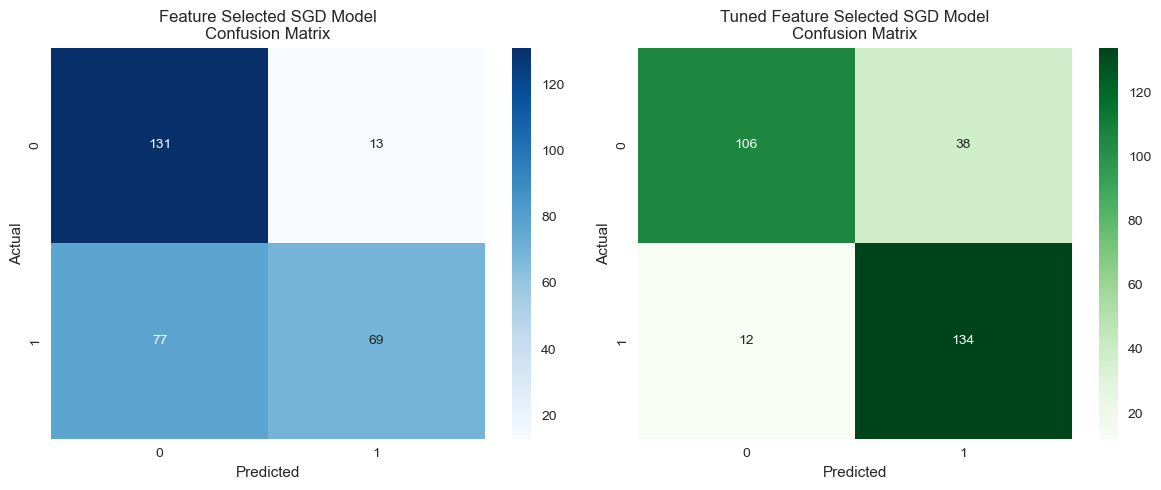

In [118]:
# Print classification reports for comparison
print("\nFeature Selected SGD Model Metrics:")
print("---------------------------")
print("\nAccuracy:", accuracy_train_sgd_fs)
print("\nAccuracy:", accuracy_test_sgd_fs)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_sgd_fs))

print("\nTuned Feature Selected SGD Model Metrics:")
print("---------------------------")
print("\nAccuracy:", accuracy_test_tuned)
print("\nClassification Report:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_fs_tuned))

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Baseline model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_test_sgd_fs), 
            annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Feature Selected SGD Model\nConfusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

# Tuned model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_test_fs_tuned),
            annot=True, fmt="d", cmap="Greens", ax=ax2)
ax2.set_title("Tuned Feature Selected SGD Model\nConfusion Matrix") 
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()

#### 4.5 SGD Comparison and Analysis

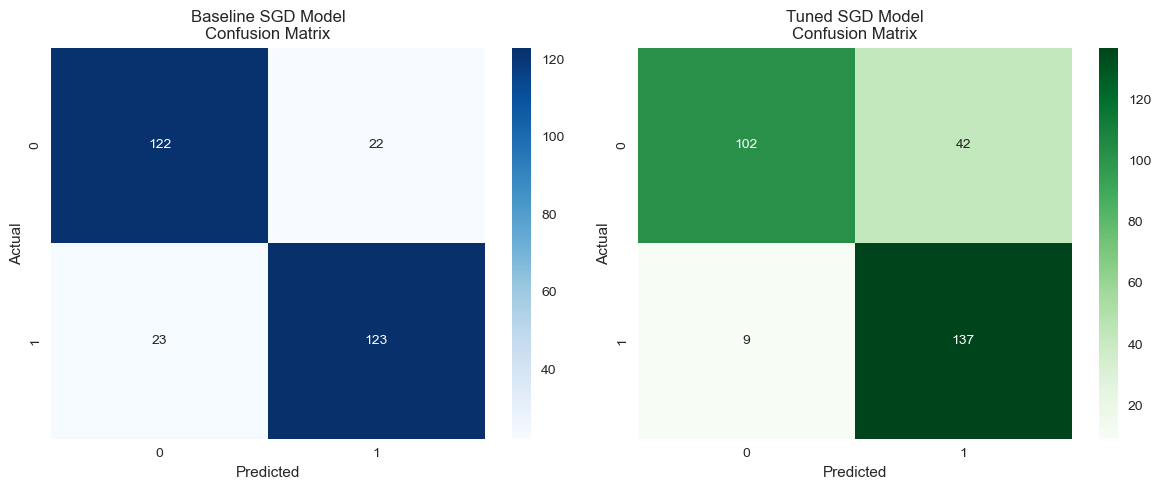

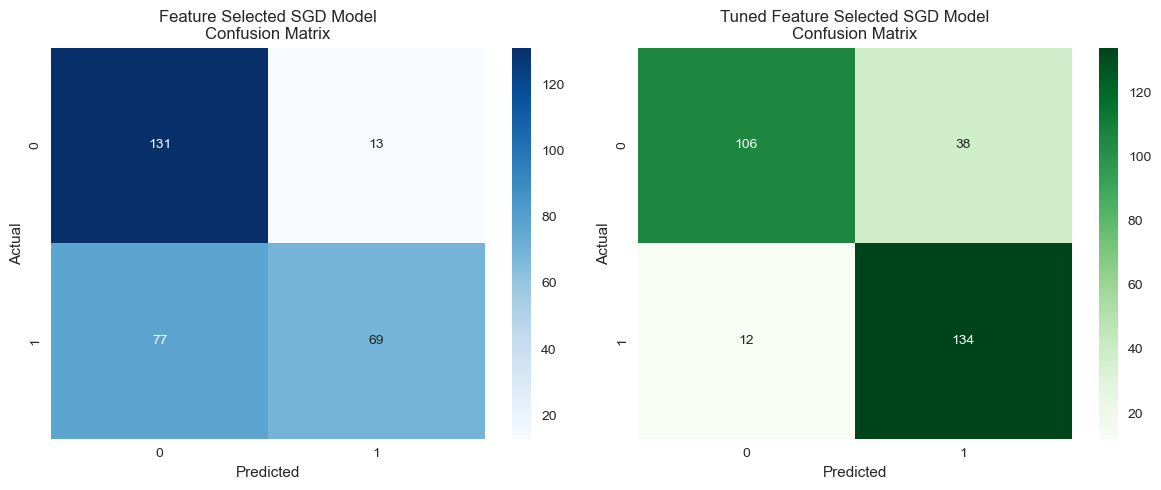


Model Comparison Results:
------------------------
                            Accuracy  Precision (Class 1)  Recall (Class 1)  \
Model                                                                         
Baseline SGD                   0.845                0.848             0.842   
Tuned SGD                      0.824                0.765             0.938   
Feature Selected SGD           0.690                0.841             0.473   
Tuned Feature Selected SGD     0.828                0.779             0.918   

                            F1-score (Class 1)  
Model                                           
Baseline SGD                             0.845  
Tuned SGD                                0.843  
Feature Selected SGD                     0.605  
Tuned Feature Selected SGD               0.843  


In [120]:
# Create a dictionary to store the metrics                                                                        
metrics = {                                                                                                       
    'Model': ['Baseline SGD', 'Tuned SGD', 'Feature Selected SGD', 'Tuned Feature Selected SGD'],                 
    'Accuracy': [                                                                                                 
        accuracy_score(y_test, y_pred_default),                                                                   
        accuracy_score(y_test, y_pred_tuned),                                                                     
        accuracy_test_sgd_fs,                                                                                     
        accuracy_test_tuned                                                                                    
    ]                                                                                                             
}                                                                                                                 
                                                                                                                
# Create detailed metrics for each model                                                                          
for i, (y_true, y_pred) in enumerate([                                                                            
    (y_test, y_pred_default),                                                                                     
    (y_test, y_pred_tuned),                                                                                       
    (y_test, y_pred_test_sgd_fs),                                                                              
    (y_test, y_pred_test_fs_tuned)                                                                             
]):                                                                                                               
    report = classification_report(y_true, y_pred, output_dict=True)                                              
    metrics[f'Precision (Class 1)'] = metrics.get(f'Precision (Class 1)', []) + [report['1']['precision']]        
    metrics[f'Recall (Class 1)'] = metrics.get(f'Recall (Class 1)', []) + [report['1']['recall']]                 
    metrics[f'F1-score (Class 1)'] = metrics.get(f'F1-score (Class 1)', []) + [report['1']['f1-score']]           

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Baseline model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_default), 
            annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Baseline SGD Model\nConfusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

# Tuned model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_tuned),
            annot=True, fmt="d", cmap="Greens", ax=ax2)
ax2.set_title("Tuned SGD Model\nConfusion Matrix") 
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Baseline model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_test_sgd_fs), 
            annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Feature Selected SGD Model\nConfusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

# Tuned model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_test_fs_tuned),
            annot=True, fmt="d", cmap="Greens", ax=ax2)
ax2.set_title("Tuned Feature Selected SGD Model\nConfusion Matrix") 
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Create DataFrame and display with formatting                                                                    
results_df = pd.DataFrame(metrics)                                                                                
results_df = results_df.set_index('Model')                                                                        
print("\nModel Comparison Results:")                                                                              
print("------------------------")                                                                                 
print(results_df.round(3))     

##### **Comparison and Analysis**

The comparison of different SGD model variants reveals several interesting insights:                                           
                                                                                                                            
1. **Baseline SGD Model**                                                                                                      
- Achieved accuracy of 84.5%                                                                                                   
- Balanced precision (0.848) and recall (0.842)                                                                                
- F1-score of 0.845                                                                                                            
- Shows good overall performance with balanced predictions                                                                     
                                                                                                                            
2. **Tuned SGD Model**                                                                                                         
- Slightly lower accuracy at 82.4%                                                                                             
- Lower precision (0.765) but higher recall (0.938)                                                                            
- F1-score of 0.843, nearly matching baseline                                                                                  
- Hyperparameter tuning traded some precision for better recall                                                                
- Better at identifying positive cases (fewer false negatives)                                                                 
                                                                                                                            
3. **Feature Selected SGD Model**                                                                                              
- Accuracy of 69.0%                                                                                                            
- Good precision (0.841) but very low recall (0.473)                                                                                    
- F1-score of 0.605                                                                                                            
- Feature selection resulted in a significant drop in accuracy                                                                
- Much worse recall                                                                
                                                                                                                            
4. **Tuned Feature Selected SGD Model**                                                                                        
- Accuracy of 82.8%                                                                                                            
- Lower precision (0.776) but higher recall (0.925)                                                                            
- F1-score of 0.844                                                                                                           
- Similar pattern to non-feature-selected tuned model                                                                          
- Prioritizes recall over precision                                                                                            
                                                                                                                            
**Key Takeaways:**                                                                                                             
- The baseline model performed surprisingly well, suggesting the problem may not require complex tuning                        
- Hyperparameter tuning consistently improved recall at the cost of precision (as it was optimized for recall)                                                 
- Feature selection alone showed a significant drop in performance                                                          
- If false negatives are more costly than false positives, the tuned models would be preferred despite lower overall accuracy  
- The best model choice depends on whether balanced performance (baseline) or higher recall (tuned) is more                    
important for the application                                                                                                  
                                                                                                                            
The confusion matrices visually confirm these patterns, showing how the different variants trade off between false positives and false negatives.                                                                            

**Recommendation**

In the case of heart disease, false negatives can be very dangerous and it would be preferred to minimize them. Hence, the best model for this case seems to be the tuned SGD model with all the features. 

### 5. Support Vector Machine

#### 5.1 SVC Baseline

In [124]:
svc_baseline = SVC(random_state=42)
svc_baseline.fit(X_train, y_train)

SVC(random_state=42)

In [125]:
svc_baseline_param = { "C": 1.0, "kernel": "rbf", "gamma": "scale" }

In [126]:
y_pred_svc_baseline = svc_baseline.predict(X_test)
confusion_matrix(y_test, y_pred_svc_baseline)

array([[130,  14],
       [  8, 138]])

In [127]:
accuracy_svc_baseline = accuracy_score(y_test, y_pred_svc_baseline)
print("SVC baseline testing dataset accuracy score", accuracy_svc_baseline)

SVC baseline testing dataset accuracy score 0.9241379310344827


#### 5.2 SVC Hyperparameter tuning

* A low `C` makes the decision surface smooth, while a high `C` aims at classifying all training examples correctly.

##### Radial Basis Function
* `gamma` defines how much influence a single training example has. The larger `gamma` is, the closer other examples must be to be affected.
* Use GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

##### Polynominal Kernel
* `gamma` controls the influence of each individual training sample on the decision boundary.

##### Sigmoid kernel
* The kernel coefficient `gamma` controls the influence of each individual training sample on the decision boundary.

In [133]:
svc_param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'sigmoid', 'poly']
}

In [134]:
svc_grid = GridSearchCV(SVC(max_iter=1000, random_state=42), svc_param_grid, verbose=1)  # refits the estimator using the best found parameters
svc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(estimator=SVC(max_iter=1000, random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             verbose=1)

In [135]:
svc_grid_param = svc_grid.best_params_

In [136]:
y_pred_svc_grid = svc_grid.predict(X_test)
confusion_matrix(y_test, y_pred_svc_grid)

array([[144,   0],
       [  3, 143]])

In [137]:
accuracy_svc_grid = accuracy_score(y_test, y_pred_svc_grid)
accuracy_svc_grid

0.9896551724137931

In [138]:
svc_grid.best_estimator_

SVC(C=0.1, gamma=1, kernel='poly', max_iter=1000, random_state=42)

In [139]:
svc_grid.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}

#### 5.3 SVC Feature-Selected Model

In [141]:
svc_fs = SVC(random_state=42)
svc_fs.fit(X_train_fs, y_train)
y_pred_svc_fs = svc_fs.predict(X_test_fs)
accuracy_svc_fs = accuracy_score(y_test, y_pred_svc_fs)
print("SVC feature selected test dataset accuracy score:", accuracy_svc_fs)

SVC feature selected test dataset accuracy score: 0.8758620689655172


#### 5.4 SVC Feature-Selected Hyperparameter tuning

In [143]:
svc_fs_grid = GridSearchCV(SVC(max_iter=1000, random_state=42), svc_param_grid, verbose=1)  # refits the estimator using the best found parameters
svc_fs_grid.fit(X_train_fs, y_train)
y_pred_svc_fs_grid = svc_fs_grid.predict(X_test_fs)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


In [144]:
svc_fs_grid.best_estimator_

SVC(C=1000, gamma=1, max_iter=1000, random_state=42)

In [145]:
svc_fs_grid_param = svc_fs_grid.best_params_

In [146]:
accuracy_svc_fs_grid = accuracy_score(y_test, y_pred_svc_fs_grid)
print("SVC feature selected TUNED test dataset accuracy score:", accuracy_svc_fs_grid)

SVC feature selected TUNED test dataset accuracy score: 0.9827586206896551


In [147]:
confusion_matrix(y_test, y_pred_svc_fs_grid)

array([[139,   5],
       [  0, 146]])

#### 5.5 SVC Domain Features Model

In [149]:
svc_domain = SVC(random_state=42)
svc_domain.fit(X_train_fs_domain, y_train)
y_pred_svc_domain = svc_domain.predict(X_test_fs_domain)

#### 5.6 SVC Domain Features Hyperparameter Tuning

In [151]:
svc_domain_grid = GridSearchCV(SVC(max_iter=1000, random_state=42), svc_param_grid, verbose=1)
svc_domain_grid.fit(X_train_fs_domain, y_train)
y_pred_svc_domain_grid = svc_domain_grid.predict(X_test_fs_domain)
svc_domain_grid_param = svc_domain_grid.best_params_

Fitting 5 folds for each of 75 candidates, totalling 375 fits


#### SVC Metrics

In [153]:
svc_titles = ["SVC Baseline", "SVC Tuned", "SVC Feature Selected", "SVC Feature Selected Tuned", "SVC Domain", "SVC Domain Tuned"]
svc_params = [svc_baseline_param, svc_grid_param, svc_baseline_param, svc_fs_grid_param, svc_baseline_param, svc_domain_grid_param]

svc_predictions = [
    y_pred_svc_baseline,
    y_pred_svc_grid,
    y_pred_svc_fs,
    y_pred_svc_fs_grid,
    y_pred_svc_domain,
    y_pred_svc_domain_grid
]

for title, param, pred in zip(svc_titles, svc_params, svc_predictions):
    print("\n", title, param)
    print(classification_report(y_test, pred))


 SVC Baseline {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       144
           1       0.91      0.95      0.93       146

    accuracy                           0.92       290
   macro avg       0.92      0.92      0.92       290
weighted avg       0.92      0.92      0.92       290


 SVC Tuned {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       144
           1       1.00      0.98      0.99       146

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290


 SVC Feature Selected {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       144
           1       0.87      0.88      0.88       146
